In [ ]:
%pip install pydub librosa matplotlib "numpy<2" "tensorflow<2.11.0" "tensorflow-gpu<2.11.0"

In [6]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성 (존재하지 않으면)
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

for file in files:
    # 파일 경로 설정
    m4a_path = os.path.join(input_dir, file)
    wav_path = os.path.join(output_dir, file.replace('.m4a', '.wav'))

    # m4a -> wav 변환
    sound = AudioSegment.from_file(m4a_path, format="m4a")
    sound.export(wav_path, format="wav")

In [1]:
import numpy as np
import librosa

# RMS 추출 함수
def extract_rms_from_file(file_path, frame_length=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms, sr

# 시퀀스 생성 함수
def create_sequences(data, window_size, stride=10):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [6]:
import os
import numpy as np

# 경로 및 파라미터 설정
wav_dir = './wav'
window_size = 20

# 전체 데이터 수집
X_all, y_all = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        rms, sr = extract_rms_from_file(file_path)
        X, y = create_sequences(rms, window_size)
        X_all.append(X)
        y_all.append(y)

# 하나의 큰 배열로 합치기
X_total = np.concatenate(X_all, axis=0)
y_total = np.concatenate(y_all, axis=0)

# LSTM 입력 형식으로 변형
X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 82178, 입력 shape: (82178, 20, 1)
총 레이블 개수: 82178, 레이블 shape: (82178,)


In [ ]:
print(X_total[0].flatten()) # 첫 번째 시퀀스 출력
print(y_total[0]) # 첫 번째 레이블 출력

[0.         0.00095597 0.04456605 0.06113401 0.07354543 0.08515146
 0.08317228 0.08389068 0.08674265 0.08750504 0.0908769  0.09072655
 0.08754595 0.08558008 0.08159105 0.0783785  0.07564511 0.0737889
 0.07197184 0.07130171]
0.07169764


Epoch 1/50
2055/2055 [==============================] - 19s 8ms/step - loss: 5.2309e-05 - val_loss: 1.8294e-05
Epoch 2/50
2055/2055 [==============================] - 15s 7ms/step - loss: 1.8214e-05 - val_loss: 1.7084e-05
Epoch 3/50
2055/2055 [==============================] - 15s 7ms/step - loss: 1.7896e-05 - val_loss: 1.8247e-05
Epoch 4/50
2055/2055 [==============================] - 15s 7ms/step - loss: 1.7322e-05 - val_loss: 1.6005e-05
Epoch 5/50
2055/2055 [==============================] - 16s 8ms/step - loss: 1.6021e-05 - val_loss: 1.5047e-05
Epoch 6/50
2055/2055 [==============================] - 16s 8ms/step - loss: 1.5943e-05 - val_loss: 1.6436e-05
Epoch 7/50
2055/2055 [==============================] - 16s 8ms/step - loss: 1.5830e-05 - val_loss: 1.4918e-05
Epoch 8/50
2055/2055 [==============================] - 15s 7ms/step - loss: 1.5760e-05 - val_loss: 1.7650e-05
Epoch 9/50
2055/2055 [==============================] - 15s 8ms/step - loss: 1.5776e-05 - val_loss: 1.5374e-05
E

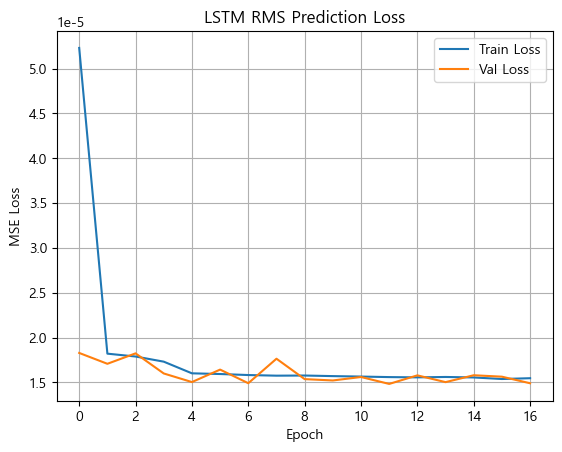

In [6]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(X_total.shape[1], 1)),
    Dense(1)  # 다음 시점의 RMS 값을 예측
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total, y_total,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_rms_model.h5')

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM RMS Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras.models import load_model  # type: ignore

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 디렉토리 설정
wav_dir = './wav'
prediction_dir = './prediction'
os.makedirs(prediction_dir, exist_ok=True)

# 하이퍼파라미터
window_size = 20
stride = 10
frame_length = 2048
hop_length = 512

# 모델 불러오기
model = load_model('lstm_rms_model.h5')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        rms, sr = extract_rms_from_file(file_path, frame_length, hop_length)

        # 시간 벡터 생성
        frames = np.arange(len(rms))
        times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

        # 시퀀스 생성
        X, y_true = create_sequences(rms, window_size, stride=stride)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # 예측
        y_pred = model.predict(X).flatten()

        # 예측용 x축 (시간 단위)
        pred_times = times[window_size::stride][:len(y_pred)]

        # 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(times, rms, label='Original RMS')
        plt.plot(pred_times, y_pred, label='Predicted RMS', color='orange')
        plt.title(f'{filename} - RMS Prediction')
        plt.xlabel('Time (s)')
        plt.ylabel('RMS')
        plt.legend()
        plt.grid(True)

        # 저장
        prediction_file_path = os.path.join(prediction_dir, f'{os.path.splitext(filename)[0]}_prediction.png')
        plt.savefig(prediction_file_path)
        plt.close()


In [2]:
import numpy as np
import librosa

# 특징 추출 함수
def extract_features_from_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    zero_crossing = librosa.feature.zero_crossing_rate(y)[0]

    # 최소 길이 맞춤
    min_len = min(len(rms), len(centroid), len(bandwidth), len(zero_crossing))
    features = np.vstack([
        rms[:min_len],
        centroid[:min_len],
        bandwidth[:min_len],
        zero_crossing[:min_len]
    ]).T

    return features, sr

# 시퀀스 생성 함수 (다변량)
def create_multivariate_sequences(data, window_size, stride=10):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])  # 다음 시점의 전체 feature 예측
    return np.array(X), np.array(y)

In [3]:
import os
import numpy as np

wav_dir = './wav'
window_size = 20
stride = 10

X_total, y_total = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        path = os.path.join(wav_dir, filename)
        features, _ = extract_features_from_file(path)
        X_seq, y_seq = create_multivariate_sequences(features, window_size, stride=stride)
        X_total.append(X_seq)
        y_total.append(y_seq)

X_total = np.vstack(X_total)
y_total = np.vstack(y_total)

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 82178, 입력 shape: (82178, 20, 4)
총 레이블 개수: 82178, 레이블 shape: (82178, 4)


Epoch 1/50
2055/2055 [==============================] - 50s 20ms/step - loss: 0.0019 - val_loss: 9.2960e-04
Epoch 2/50
2055/2055 [==============================] - 33s 16ms/step - loss: 5.7798e-04 - val_loss: 7.9276e-04
Epoch 3/50
2055/2055 [==============================] - 35s 17ms/step - loss: 5.1726e-04 - val_loss: 6.5928e-04
Epoch 4/50
2055/2055 [==============================] - 36s 18ms/step - loss: 4.8813e-04 - val_loss: 6.6624e-04
Epoch 5/50
2055/2055 [==============================] - 27s 13ms/step - loss: 4.7488e-04 - val_loss: 6.3062e-04
Epoch 6/50
2055/2055 [==============================] - 22s 11ms/step - loss: 4.6656e-04 - val_loss: 6.6306e-04
Epoch 7/50
2055/2055 [==============================] - 24s 12ms/step - loss: 4.5513e-04 - val_loss: 6.2736e-04
Epoch 8/50
2055/2055 [==============================] - 24s 12ms/step - loss: 4.4392e-04 - val_loss: 6.8694e-04
Epoch 9/50
2055/2055 [==============================] - 24s 12ms/step - loss: 4.3480e-04 - val_loss: 6.3536e

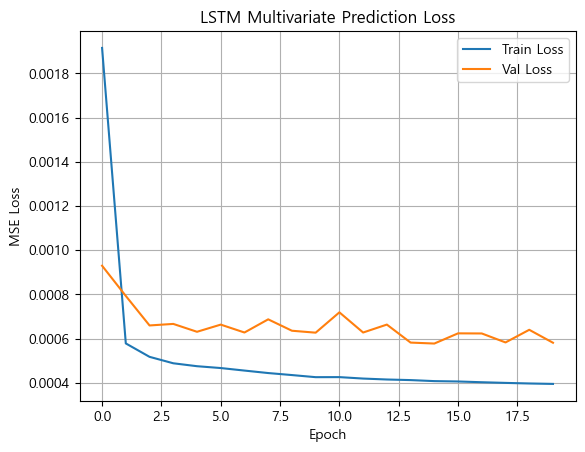

In [9]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from joblib import dump

scaler = MinMaxScaler()
X_total_scaled = scaler.fit_transform(X_total.reshape(-1, X_total.shape[-1])).reshape(X_total.shape)
y_total_scaled = scaler.fit_transform(y_total)
dump(scaler, 'scaler_y.joblib')

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(window_size, 4), return_sequences=True),
    TimeDistributed(Dense(64)),  # 시계열 각 시점별로 Dense(32) 적용
    LSTM(32),
    Dense(16),
    Dense(4)  # 다음 시점의 모든 feature 예측: [RMS, 중심주파수, 주파수폭, 제로크로싱]
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total_scaled, y_total_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_all_feature_predictor.h5')

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Multivariate Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from tensorflow.keras.models import load_model # type: ignore
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from joblib import load

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

feature_dir = './feature_prediction'
os.makedirs(feature_dir, exist_ok=True)

stride=10
hop_length=512

# 모델 로드
model = load_model('lstm_all_feature_predictor.h5')
scaler = load('scaler_y.joblib')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        path = os.path.join(wav_dir, filename)
        features, sr = extract_features_from_file(path)
        X, y_true = create_multivariate_sequences(features, window_size, stride=stride)
        X_scaled = scaler.transform(X.reshape(-1, 4)).reshape(X.shape)

        y_pred_scaled = model.predict(X_scaled)
        y_pred = scaler.inverse_transform(y_pred_scaled)  # 역정규화

        # 시간축
        frames = np.arange(len(features))
        times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
        pred_times = times[window_size::stride][:len(y_pred)]

        # 시각화
        feature_names = ['RMS', 'Centroid', 'Bandwidth', 'ZCR']
        for i in range(4):
            plt.figure(figsize=(10, 4))
            plt.plot(times, features[:, i], label=f'Original {feature_names[i]}')
            plt.plot(pred_times, y_pred[:, i], label=f'Predicted {feature_names[i]}', color='orange')
            plt.title(f'{filename} - {feature_names[i]} Prediction')
            plt.xlabel('Time (s)')
            plt.ylabel(feature_names[i])
            plt.legend()
            plt.grid(True)

            save_path = os.path.join(feature_dir, f"{os.path.splitext(filename)[0]}_{feature_names[i]}.png")
            plt.savefig(save_path)
            plt.close()

17/17 [==============================] - 0s 4ms/step
